In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/IAmNelu/DeepVoiceSP.git
%cd DeepVoiceSP/

Cloning into 'DeepVoiceSP'...
remote: Enumerating objects: 397, done.
remote: Counting objects: 100% (397/397), done.
remote: Compressing objects: 100% (273/273), done.
remote: Total 397 (delta 246), reused 266 (delta 121), pack-reused 0
Receiving objects: 100% (397/397), 502.09 KiB | 5.77 MiB/s, done.
Resolving deltas: 100% (246/246), done.
/content/DeepVoiceSP


In [3]:
!mkdir checkpoints
!unzip ../drive/MyDrive/Voice_Conversion_SP/checkpoints/mfcc2ppg.zip -d  checkpoints

Archive:  ../drive/MyDrive/Voice_Conversion_SP/checkpoints/mfcc2ppg.zip
  inflating: checkpoints/mfcc2ppg.ckpt.data-00000-of-00001  
  inflating: checkpoints/mfcc2ppg.ckpt.index  


In [4]:
!pip -q install pydub
!pip -q install pysptk 


     |████████████████████████████████| 419kB 13.6MB/s 


In [5]:
import sys
import json
import numpy as np
import pysptk
import tensorflow as tf
sys.path.insert(0,'./utils')
import data_preparation as dp
import padding_functions as pf 
import DBLSTM_MFCC_PPG as mfcc2ppg
import DBLSTM_PPG_MCEP as ppgs2mcep

# all imports
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
from io import BytesIO
from pydub import AudioSegment
import librosa
import matplotlib.pyplot as plt
import IPython
plt.style.use("ggplot")

In [6]:
# Configuration parameters

DIM_PPGS = 40
SAMPLING_RATE = 16000
N_MFCC = 39
N_FFT = 512
HOP_LEN = 160
BTCH_SIZE = 6
HIDDEN_UNITS = 512
CHECKPOINT_NET = "checkpoints/mfcc2ppg.ckpt"

In [7]:
dictpath = "config_files/label_dict_"+str(DIM_PPGS)+".json"
inverse_dictpath = "config_files/label_inv_dict_"+str(DIM_PPGS)+".json"
transcriptor =  dp.load_json_dict(dictpath)

In [8]:
converter = mfcc2ppg.DBLSTM(batch_size=BTCH_SIZE, 
                              n_mffc=N_MFCC,
                              hidden_units=HIDDEN_UNITS,
                              out_classes=DIM_PPGS)  
               
converter.load_weights(CHECKPOINT_NET)

## Second System Loading

In [9]:
TARGET_USR = "p284"

checkpoint_base = "../drive/MyDrive/Voice_Conversion_SP/checkpoints/" 

In [10]:
# Configuration parameters
DIM_MCEPS = 31
DIM_PPGS = 40
BTCH_SIZE2 = 24
HIDDEN_UNITS = 512

target_scaler = checkpoint_base + TARGET_USR + "scaler.json"

CHECKPOINT_NET2 = checkpoint_base + TARGET_USR + "_ppg2mcep.ckpt"

In [11]:
target_scaler = dp.load_json_dict(target_scaler)
target_scaler['mean'] = np.array(target_scaler['mean'])
target_scaler['std'] = np.array(target_scaler['std'])

In [12]:
transformer = ppgs2mcep.DBLSTM(dim_ppgs=DIM_PPGS, dim_mceps=DIM_MCEPS, hidden_units=HIDDEN_UNITS, 
                          batch_size=BTCH_SIZE2, 
                          scaler=target_scaler)
                        
transformer.load_model(CHECKPOINT_NET2)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


## Load audio to be converted

In [33]:
## UPLOAD ONLY .WAV FILE
try:
    from google.colab import files
except ImportError:
    print("ImportError: files from google.colab seems to not be available")
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
uploaded_file_name = next(iter(uploaded))
print('Uploaded file: ' + uploaded_file_name)

Saving SI1375.WAV to SI1375.WAV
User uploaded file "SI1375.WAV" with length 141928 bytes
Uploaded file: SI1375.WAV


#### get mfcc from input file

In [34]:
x, _ = librosa.load(uploaded_file_name, sr=SAMPLING_RATE)
mfccs = librosa.feature.mfcc(y=x, sr=SAMPLING_RATE,
                                n_mfcc=N_MFCC,
                                n_fft=N_FFT,
                                hop_length=HOP_LEN)

In [35]:
#NORMALIZE TO USE THE NETWORK
mfccs_norm = dp.normalize_mfcc(mfccs.T)

#### Extract ppgs from input audio

In [36]:
ppg_sentence = converter.predict(mfccs_norm)

#### Transform ppgs to target mcep

In [37]:
mcep_final = transformer.predict(ppg_sentence).numpy()

#### Process all info to get new waveform

In [38]:
!pip install pyworld
import pyworld as pw

In [39]:
x = x.astype(np.float64)

_f0, t = pw.dio(x, SAMPLING_RATE)# frame_period=10)
f0_try = pw.stonemask(x, _f0, t, SAMPLING_RATE) #refinement of f0 using stone mask
ap_try = pw.d4c(x=x, f0=_f0, temporal_positions=t, fs=SAMPLING_RATE,fft_size=N_FFT)

In [40]:
alpha=0.35
fftl=512

indices = sorted(np.concatenate([np.arange(len(mcep_final))]*2))
spc = pysptk.mc2sp(mcep_final[indices], alpha, fftl).astype(np.float64)[:len(f0_try)]

print(spc.shape)

(881, 257)


In [41]:
y2 = pw.synthesize(f0_try, spc, ap_try, SAMPLING_RATE)

#### Play and compare old and new audios

In [42]:
x = x.astype(np.float64)
_f0, t = pw.dio(x, SAMPLING_RATE)    # raw pitch extractor
f0 = pw.stonemask(x, _f0, t, SAMPLING_RATE)  # pitch refinement
sp = pw.cheaptrick(x, f0, t, SAMPLING_RATE)  # extract smoothed spectrogram
ap = pw.d4c(x, f0, t, SAMPLING_RATE)         # extract aperiodicity

y = pw.synthesize(f0, sp, ap, SAMPLING_RATE)

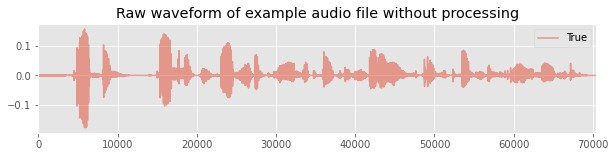

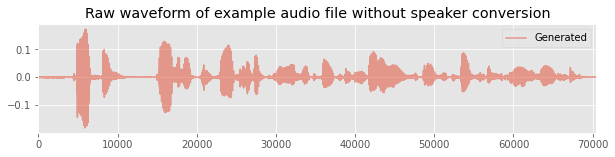

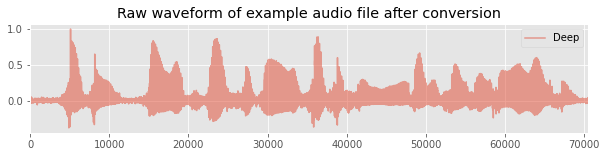

In [43]:
fig_size= (10,2)
plt.style.use("ggplot")
plt.figure(figsize=fig_size)
plt.title("Raw waveform of example audio file without processing")
plt.plot(x, alpha=0.5, label="True")
plt.xlim(0, len(x))
plt.legend()
plt.figure(figsize=fig_size)
plt.title("Raw waveform of example audio file without speaker conversion")
plt.plot(y, alpha=0.5, label="Generated")
plt.xlim(0, len(y))
plt.legend()
plt.figure(figsize=fig_size)
plt.title("Raw waveform of example audio file after conversion")
plt.plot(y2/np.max(abs(y2)), alpha=0.5, label="Deep")
plt.xlim(0, len(y2))
plt.legend()


In [44]:
IPython.display.Audio(x, rate=SAMPLING_RATE)

In [45]:
IPython.display.Audio(y, rate=SAMPLING_RATE)

In [46]:
IPython.display.Audio(y2/np.max(abs(y2)), rate=SAMPLING_RATE)